**AIS Vessel Track Exploration and Analysis**

This notebook provides exploratory data analysis of AIS (Automatic Identification System) vessel trajectories in US waters during 2024. It analyzes individual vessel behavior patterns, movement characteristics, and temporal activity patterns.

**Key Analysis Areas:**
- Individual vessel track visualization
- Temporal activity patterns (daily, monthly, hourly)
- Movement state analysis (static vs. moving)
- Speed profile analysis
- Activity heatmaps by time and day of week

In [1]:
# Imports and Environment Verification
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import sys
import os
from dotenv import load_dotenv
print(f"Python executable: {sys.executable}")
print(f"Virtual environment active: {'venv' in sys.executable}")

# Load environment variables from .env file
load_dotenv()
print("Environment variables loaded from .env file")

import psycopg2
from psycopg2.extras import RealDictCursor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.animation as animation
import seaborn as sns
from datetime import datetime

Python executable: c:\Users\Jorge\Projects\unipi-ds-charikiopoulos-thesis\venv\Scripts\python.exe
Virtual environment active: True
Environment variables loaded from .env file


In [2]:
# Connect to PostgreSQL database using environment variables
conn = psycopg2.connect(
    host=os.getenv('DB_HOST', 'localhost'),
    database=os.getenv('DB_NAME', 'postgres'),
    user=os.getenv('DB_USER', 'postgres'),
    password=os.getenv('DB_PASSWORD'),
    port=os.getenv('DB_PORT', '5432')
)

cursor = conn.cursor(cursor_factory=RealDictCursor)
    
# SQL query to fetch data
query = """
SELECT
    mmsi,
    lat,
    lon,
    datetime_utc,
    sog,
    cog,
    vessel_name,
    vessel_type,
    CASE
        WHEN vessel_type = 30 THEN 'fishing'
        WHEN vessel_type BETWEEN 60 AND 69 THEN 'passenger'
        WHEN vessel_type BETWEEN 70 AND 79 THEN 'cargo'
        WHEN vessel_type BETWEEN 80 AND 89 THEN 'tanker'
        ELSE 'other'
    END AS vessel_category
FROM
    vessel_positions_raw
WHERE
    vessel_type = 30  -- Fishing vessels
    AND mmsi = 367643270  -- Example MMSI for detailed analysis
ORDER BY
    mmsi,
    datetime_utc ASC
;
"""

# Load data into a Pandas DataFrame
cursor.execute(query)
data = cursor.fetchall()
cursor.close()
conn.close()

df = pd.DataFrame(data)

# Print total number of rows
print(f'Total number of positions: {len(df)}\n')

# Display basic information about the dataset
print(f"Dataset Overview:")
print(f"- Unique vessels (MMSIs): {df['mmsi'].nunique()}")
print(f"- Date range: {df['datetime_utc'].min()} to {df['datetime_utc'].max()}")
print(f"- Vessel categories: {df['vessel_category'].unique()}")

# Display the first 10 rows of the DataFrame, only datetime, lat, lon, and speed columns
sample_cols = ['datetime_utc', 'lat', 'lon', 'sog', 'vessel_category']
print(f"\nFirst 10 rows of the DataFrame:")
print(df[sample_cols].head(10))

Total number of positions: 5987

Dataset Overview:
- Unique vessels (MMSIs): 1
- Date range: 2024-01-01 00:00:00 to 2024-12-31 23:00:09
- Vessel categories: ['fishing']

First 10 rows of the DataFrame:
         datetime_utc       lat       lon  sog vessel_category
0 2024-01-01 00:00:00  31.15515 -87.97491  0.9         fishing
1 2024-01-01 01:00:02  31.14945 -87.94519  4.5         fishing
2 2024-01-01 02:00:06  31.08583 -87.97687  4.5         fishing
3 2024-01-01 03:00:06  31.04327 -88.00262  4.7         fishing
4 2024-01-01 04:00:06  31.01178 -88.01594  4.4         fishing
5 2024-01-01 05:00:05  30.97030 -87.99278  4.5         fishing
6 2024-01-01 06:00:06  30.91693 -87.96518  4.3         fishing
7 2024-01-01 07:00:06  30.86229 -87.98160  4.2         fishing
8 2024-01-01 08:00:06  30.82033 -87.96314  4.3         fishing
9 2024-01-01 09:00:06  30.78065 -88.01620  4.5         fishing


In [3]:
# Preprocess and analyze vessel trajectory data

# Select the sample vessel for analysis
sample_mmsi = df['mmsi'].unique()[0]
df_vessel = df[df['mmsi'] == sample_mmsi].copy()

# Sort by datetime and convert to proper datetime format
df_vessel = df_vessel.sort_values('datetime_utc')
df_vessel['datetime_utc'] = pd.to_datetime(df_vessel['datetime_utc'])

# Basic statistics about the selected vessel
print(f"Analysis for vessel MMSI: {sample_mmsi}")
print(f"Vessel category: {df_vessel['vessel_category'].iloc[0]}")
print(f"Total position reports: {len(df_vessel)}")
print(f"Time span: {df_vessel['datetime_utc'].min()} to {df_vessel['datetime_utc'].max()}")
print(f"Geographic bounds:")
print(f"  Latitude: {df_vessel['lat'].min():.4f} to {df_vessel['lat'].max():.4f}")
print(f"  Longitude: {df_vessel['lon'].min():.4f} to {df_vessel['lon'].max():.4f}")

# Resample data to daily frequency and count the number of positions per day
daily_positions = df_vessel.resample('D', on='datetime_utc').size()
print(f"\nDaily position reports for MMSI {sample_mmsi}:")
print(daily_positions.head(20))

Analysis for vessel MMSI: 367643270
Vessel category: fishing
Total position reports: 5987
Time span: 2024-01-01 00:00:00 to 2024-12-31 23:00:09
Geographic bounds:
  Latitude: 29.8363 to 31.1615
  Longitude: -90.1970 to -87.9383

Daily position reports for MMSI 367643270:
datetime_utc
2024-01-01    18
2024-01-02    16
2024-01-03    12
2024-01-04    17
2024-01-05    20
2024-01-06    13
2024-01-07    22
2024-01-08    18
2024-01-09    13
2024-01-10    15
2024-01-11    16
2024-01-12    19
2024-01-13    14
2024-01-14    15
2024-01-15    24
2024-01-16    14
2024-01-17    21
2024-01-18    14
2024-01-19    22
2024-01-20    11
Freq: D, dtype: int64


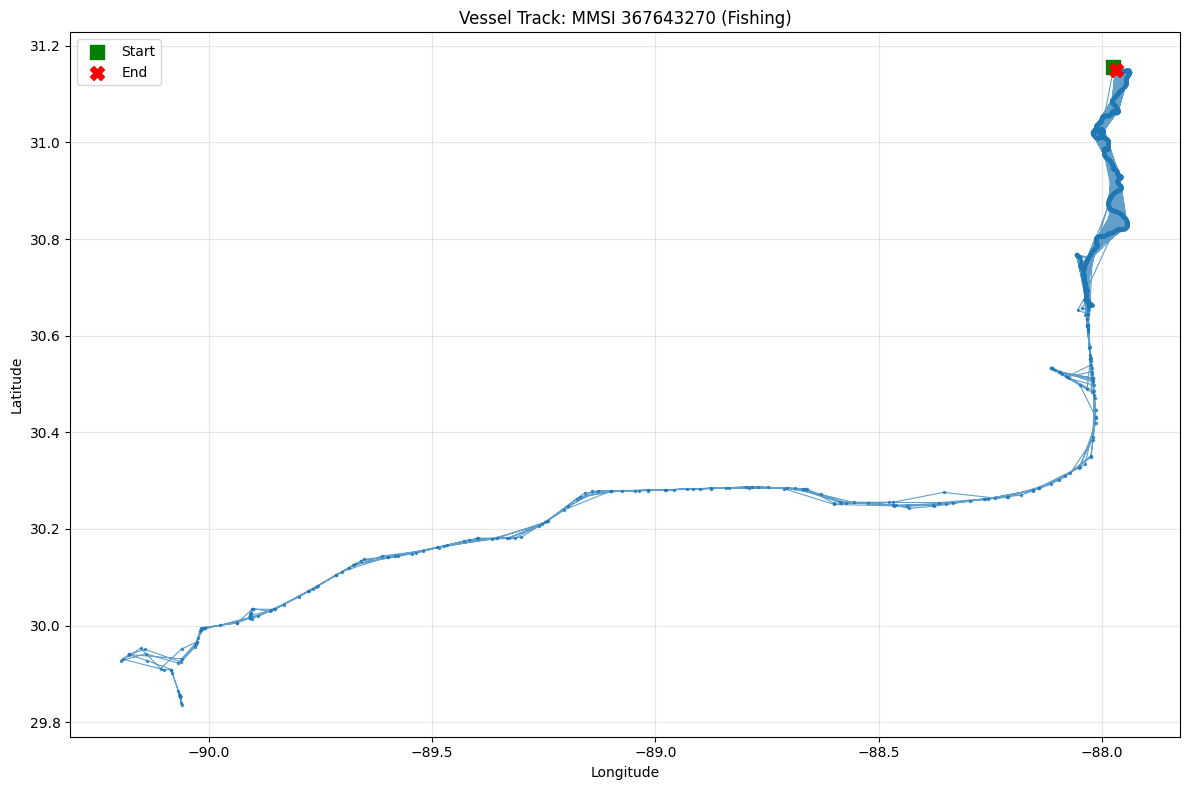

Trajectory Analysis:
- Total track points: 5987
- Geographic coverage:
  * Latitude range: 1.3251 degrees
  * Longitude range: 2.2587 degrees


In [19]:
# Visualize vessel trajectory on a map

plt.figure(figsize=(12, 8))
plt.plot(df_vessel['lon'], df_vessel['lat'], marker='o', markersize=1.5, linewidth=0.8, alpha=0.7)
plt.scatter(df_vessel['lon'].iloc[0], df_vessel['lat'].iloc[0], 
           color='green', s=100, marker='s', label='Start', zorder=5)
plt.scatter(df_vessel['lon'].iloc[-1], df_vessel['lat'].iloc[-1], 
           color='red', s=100, marker='X', label='End', zorder=5)

plt.title(f'Vessel Track: MMSI {sample_mmsi} ({df_vessel["vessel_category"].iloc[0].title()})')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display trajectory statistics
print(f"Trajectory Analysis:")
print(f"- Total track points: {len(df_vessel)}")
print(f"- Geographic coverage:")
print(f"  * Latitude range: {df_vessel['lat'].max() - df_vessel['lat'].min():.4f} degrees")
print(f"  * Longitude range: {df_vessel['lon'].max() - df_vessel['lon'].min():.4f} degrees")

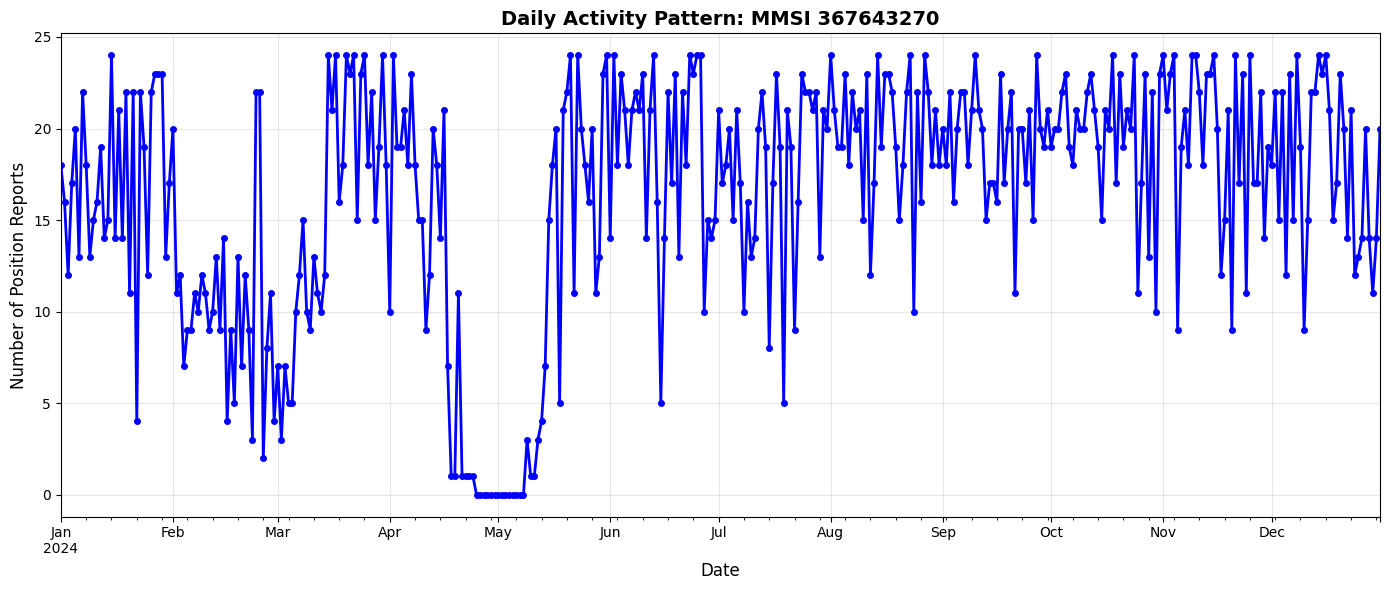

Daily Activity Statistics:
- Average positions per day: 16.4
- Maximum positions in a day: 24
- Minimum positions in a day: 0
- Standard deviation: 6.6
- Days with activity: 352
- Days without activity: 14


In [20]:
# Plot daily activity
plt.figure(figsize=(14, 6))
daily_positions.plot(kind='line', marker='o', color='blue', linewidth=2, markersize=4)
plt.title(f'Daily Activity Pattern: MMSI {sample_mmsi}', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Position Reports', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate and display daily activity statistics
print(f"Daily Activity Statistics:")
print(f"- Average positions per day: {daily_positions.mean():.1f}")
print(f"- Maximum positions in a day: {daily_positions.max()}")
print(f"- Minimum positions in a day: {daily_positions.min()}")
print(f"- Standard deviation: {daily_positions.std():.1f}")
print(f"- Days with activity: {(daily_positions > 0).sum()}")
print(f"- Days without activity: {(daily_positions == 0).sum()}")

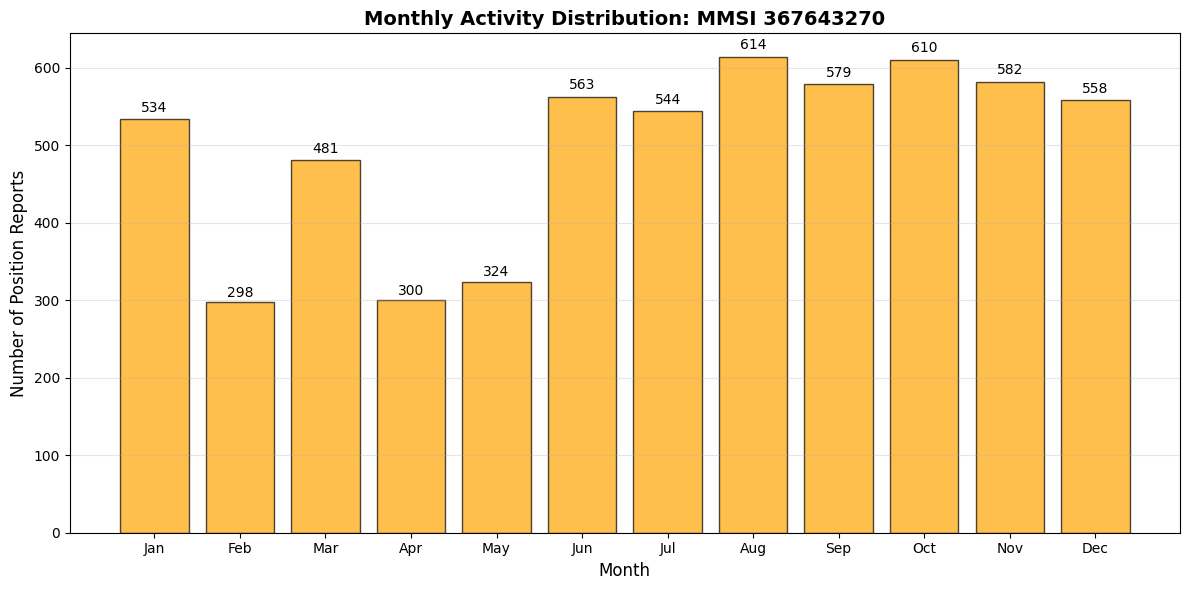

Monthly Activity Analysis:
- Jan: 534 positions (8.9% of total)
- Feb: 298 positions (5.0% of total)
- Mar: 481 positions (8.0% of total)
- Apr: 300 positions (5.0% of total)
- May: 324 positions (5.4% of total)
- Jun: 563 positions (9.4% of total)
- Jul: 544 positions (9.1% of total)
- Aug: 614 positions (10.3% of total)
- Sep: 579 positions (9.7% of total)
- Oct: 610 positions (10.2% of total)
- Nov: 582 positions (9.7% of total)
- Dec: 558 positions (9.3% of total)


In [21]:
# Analyze temporal patterns: monthly and weekly activity

# Extract temporal features
df_vessel = df_vessel.copy()
df_vessel['month'] = df_vessel['datetime_utc'].dt.month
df_vessel['day_of_week'] = df_vessel['datetime_utc'].dt.day_name()
df_vessel['hour'] = df_vessel['datetime_utc'].dt.hour

# Group by month and count positions
monthly_positions = df_vessel.groupby('month').size()

# Plot monthly activity
plt.figure(figsize=(12, 6))
bars = plt.bar(monthly_positions.index, monthly_positions.values, color='orange', alpha=0.7, edgecolor='black')
plt.title(f'Monthly Activity Distribution: MMSI {sample_mmsi}', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Position Reports', fontsize=12)

# Add month labels
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(ticks=range(1, 13), labels=[month_labels[i-1] for i in range(1, 13) if i in monthly_positions.index])

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Display monthly statistics
print(f"Monthly Activity Analysis:")
for month, count in monthly_positions.items():
    month_name = month_labels[month-1]
    print(f"- {month_name}: {count} positions ({count/len(df_vessel)*100:.1f}% of total)")

Movement State Analysis:
- Total positions: 5987
- Static positions: 1282 (21.4%)
- Moving positions: 4705 (78.6%)
- Static threshold: 0.5 knots


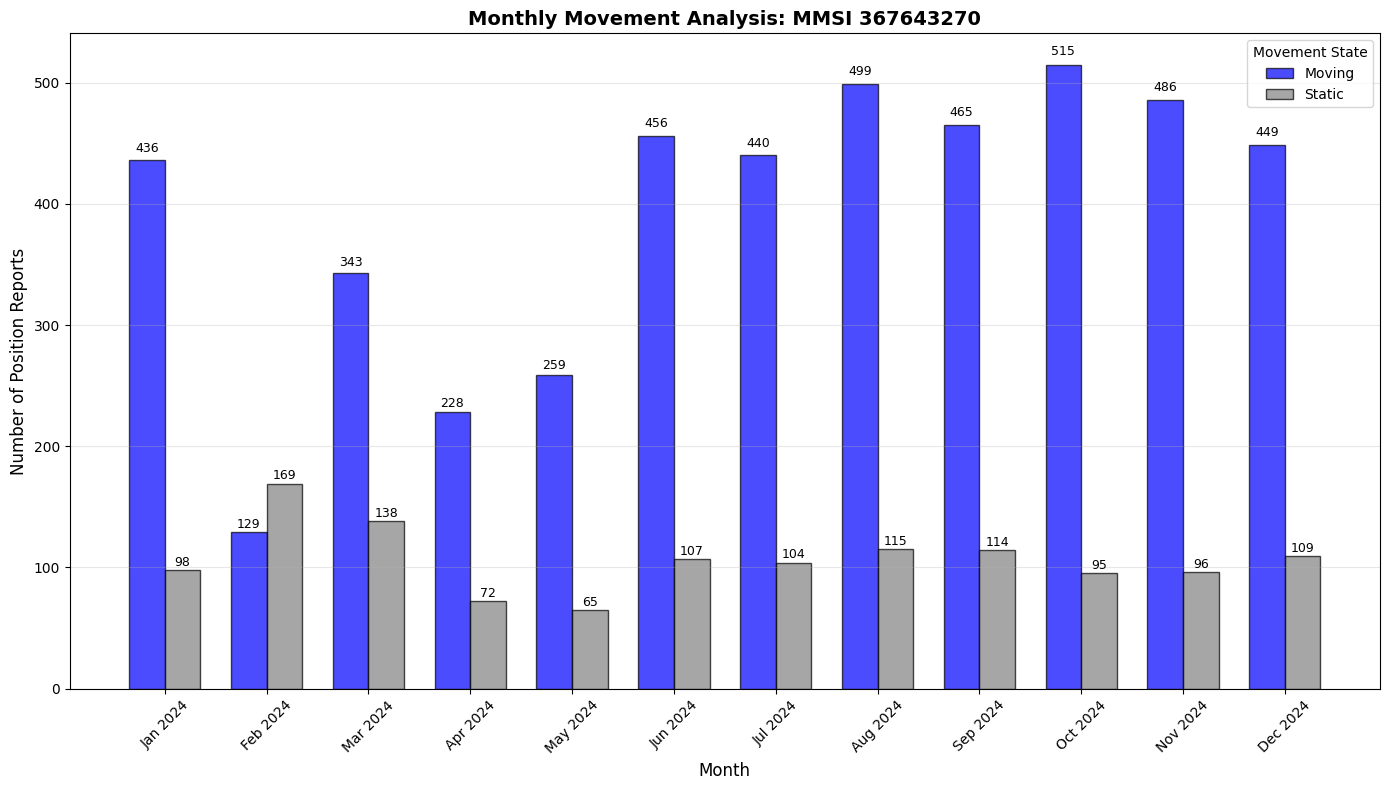

In [22]:
# Analyze vessel movement states: static vs moving behavior

# Define threshold for determining if the vessel is static
STATIC_THRESHOLD = 0.5  # Speed in knots

# Add movement state classification
df_vessel = df_vessel.copy()
df_vessel['state'] = df_vessel['sog'].apply(lambda x: 'Static' if x < STATIC_THRESHOLD else 'Moving')

# Calculate overall movement statistics
total_positions = len(df_vessel)
static_count = (df_vessel['state'] == 'Static').sum()
moving_count = (df_vessel['state'] == 'Moving').sum()

print(f"Movement State Analysis:")
print(f"- Total positions: {total_positions}")
print(f"- Static positions: {static_count} ({static_count/total_positions*100:.1f}%)")
print(f"- Moving positions: {moving_count} ({moving_count/total_positions*100:.1f}%)")
print(f"- Static threshold: {STATIC_THRESHOLD} knots")

# Resample data to monthly frequency and analyze movement states
monthly_activity = df_vessel.resample('MS', on='datetime_utc')['state'].value_counts().unstack(fill_value=0)

# Handle case where some states might be missing
if 'Moving' not in monthly_activity.columns:
    monthly_activity['Moving'] = 0
if 'Static' not in monthly_activity.columns:
    monthly_activity['Static'] = 0

# Reset index to have datetime as column
monthly_activity = monthly_activity.reset_index()

# Create the visualization
fig, ax = plt.subplots(figsize=(14, 8))

# X-axis positioning
x = range(len(monthly_activity))
width = 0.35

# Create bars
bars1 = ax.bar([i - width/2 for i in x], monthly_activity['Moving'], 
               width, label='Moving', color='blue', alpha=0.7, edgecolor='black')
bars2 = ax.bar([i + width/2 for i in x], monthly_activity['Static'], 
               width, label='Static', color='grey', alpha=0.7, edgecolor='black')

# Format the plot
ax.set_title(f'Monthly Movement Analysis: MMSI {sample_mmsi}', fontsize=14, fontweight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Number of Position Reports', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels([date.strftime('%b %Y') for date in monthly_activity['datetime_utc']], rotation=45)
ax.legend(title='Movement State')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                   f'{int(height)}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()



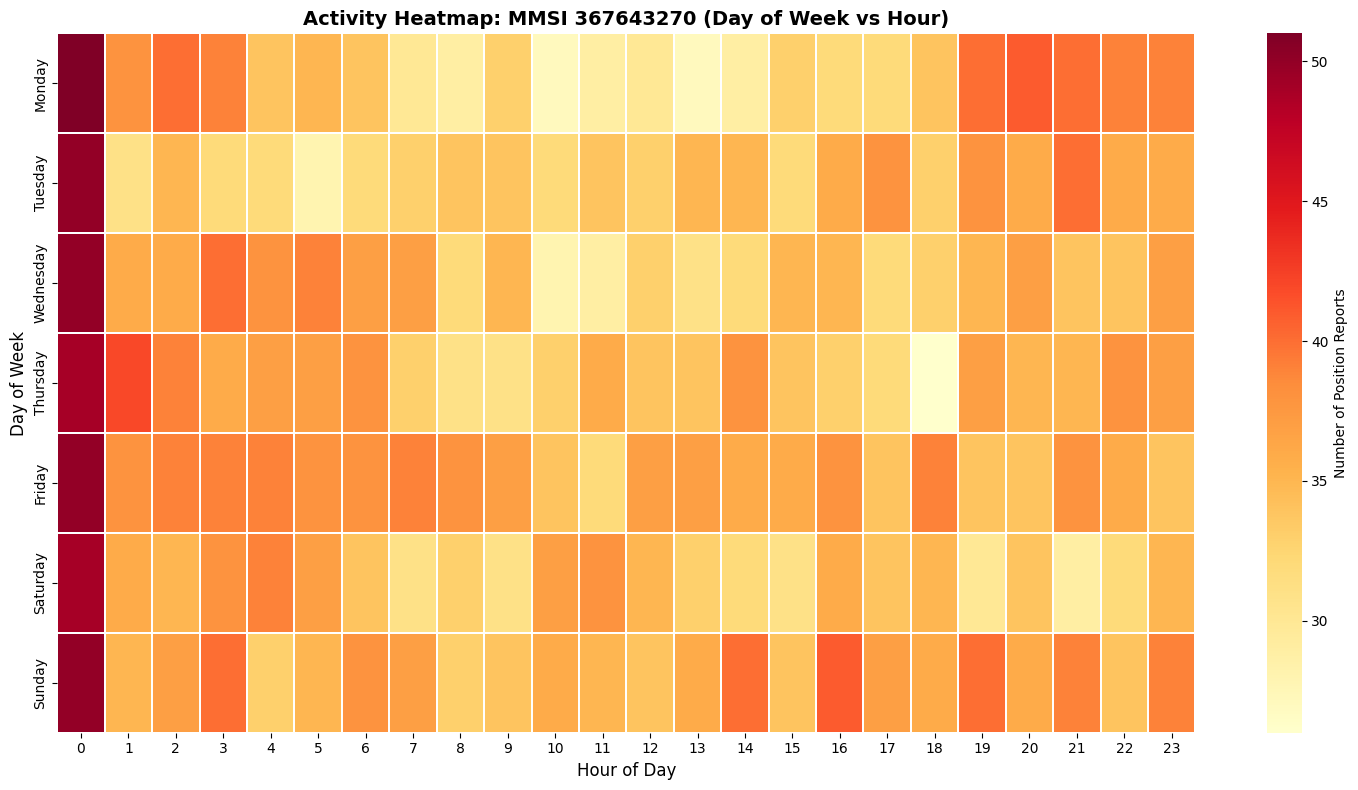

Activity by Day of Week:
- Monday: 835 positions (13.9%)
- Tuesday: 835 positions (13.9%)
- Wednesday: 845 positions (14.1%)
- Thursday: 855 positions (14.3%)
- Friday: 894 positions (14.9%)
- Saturday: 834 positions (13.9%)
- Sunday: 889 positions (14.8%)

Peak Activity Hours:
- Hour 00:00: 349 positions (5.8%)
- Hour 03:00: 264 positions (4.4%)
- Hour 02:00: 261 positions (4.4%)
- Hour 23:00: 257 positions (4.3%)
- Hour 01:00: 256 positions (4.3%)


In [23]:
# Create vessel activity heatmap: day of week vs hour of day

# Ensure we have the temporal columns
if 'day_of_week' not in df_vessel.columns:
    df_vessel['day_of_week'] = df_vessel['datetime_utc'].dt.day_name()
if 'hour' not in df_vessel.columns:
    df_vessel['hour'] = df_vessel['datetime_utc'].dt.hour

# Create a pivot table for heatmap
heatmap_data = df_vessel.pivot_table(
    index='day_of_week', 
    columns='hour', 
    values='mmsi', 
    aggfunc='count'
).fillna(0)

# Reorder days of the week to start with Monday
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex([day for day in day_order if day in heatmap_data.index])

# Plot heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_data, 
            cmap='YlOrRd', 
            annot=False, 
            fmt='.0f', 
            cbar_kws={'label': 'Number of Position Reports'},
            linewidths=0.1)

plt.title(f'Activity Heatmap: MMSI {sample_mmsi} (Day of Week vs Hour)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Day of Week', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate and display activity statistics by day of week
print(f"Activity by Day of Week:")
daily_totals = df_vessel.groupby('day_of_week').size()
for day in day_order:
    if day in daily_totals.index:
        count = daily_totals[day]
        percentage = count / len(df_vessel) * 100
        print(f"- {day}: {count} positions ({percentage:.1f}%)")

# Calculate peak activity hours
print(f"\nPeak Activity Hours:")
hourly_totals = df_vessel.groupby('hour').size().sort_values(ascending=False)
for hour in hourly_totals.head(5).index:
    count = hourly_totals[hour]
    percentage = count / len(df_vessel) * 100
    print(f"- Hour {hour:02d}:00: {count} positions ({percentage:.1f}%)")

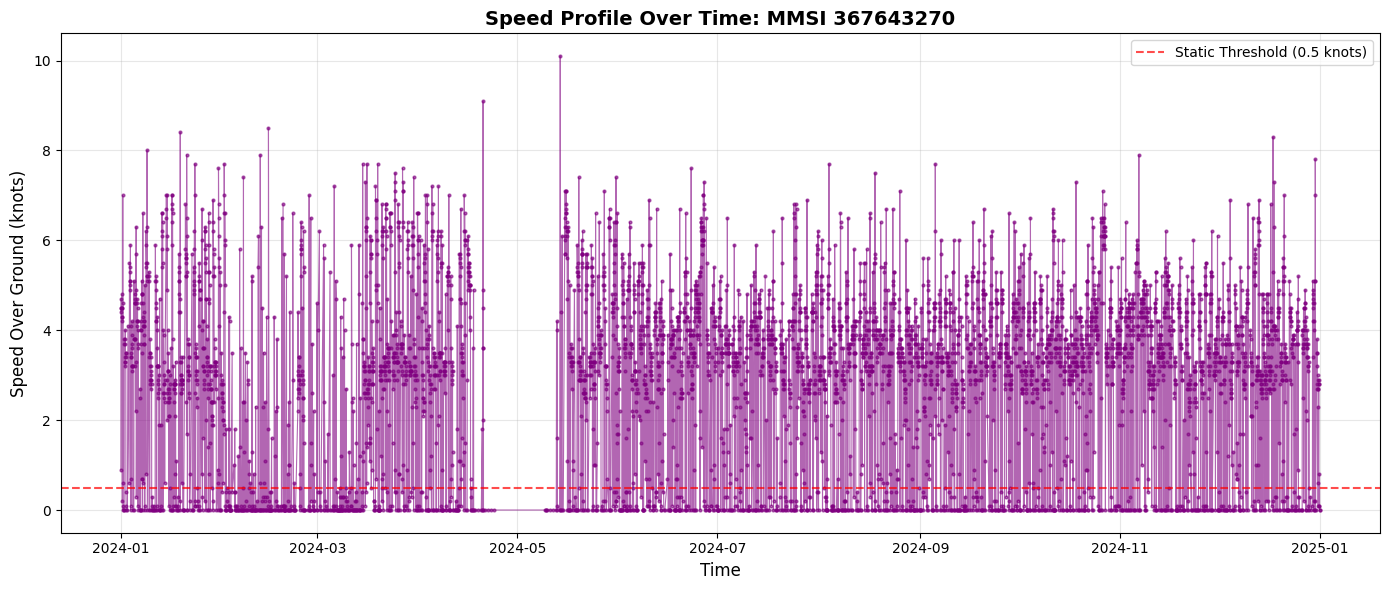

Speed Analysis Statistics:
- Count: 5987 valid readings
- Mean speed: 2.99 knots
- Median speed: 3.30 knots
- Standard deviation: 1.92 knots
- Minimum speed: 0.00 knots
- Maximum speed: 10.10 knots

Speed Distribution:
- Stationary (< 0.5 knots): 1282 reports (21.4%)
- Low speed (0.5-2 knots): 333 reports
- Medium speed (2-5 knots): 3571 reports
- High speed (≥5 knots): 801 reports


In [24]:
# Analyze vessel speed patterns over time

# Filter out invalid speed values (negative speeds)
df_speed = df_vessel[df_vessel['sog'] >= 0].copy()

plt.figure(figsize=(14, 6))
plt.plot(df_speed['datetime_utc'], df_speed['sog'], 
         marker='o', linestyle='-', color='purple', alpha=0.6, markersize=2, linewidth=0.8)

# Add horizontal line for static threshold
plt.axhline(y=STATIC_THRESHOLD, color='red', linestyle='--', alpha=0.7, 
           label=f'Static Threshold ({STATIC_THRESHOLD} knots)')

plt.title(f'Speed Profile Over Time: MMSI {sample_mmsi}', fontsize=14, fontweight='bold')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Speed Over Ground (knots)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate speed statistics
speed_stats = df_speed['sog'].describe()
print(f"Speed Analysis Statistics:")
print(f"- Count: {speed_stats['count']:.0f} valid readings")
print(f"- Mean speed: {speed_stats['mean']:.2f} knots")
print(f"- Median speed: {speed_stats['50%']:.2f} knots")
print(f"- Standard deviation: {speed_stats['std']:.2f} knots")
print(f"- Minimum speed: {speed_stats['min']:.2f} knots")
print(f"- Maximum speed: {speed_stats['max']:.2f} knots")

# Speed distribution analysis
print(f"\nSpeed Distribution:")
print(f"- Stationary (< {STATIC_THRESHOLD} knots): {(df_speed['sog'] < STATIC_THRESHOLD).sum()} reports ({(df_speed['sog'] < STATIC_THRESHOLD).mean()*100:.1f}%)")
print(f"- Low speed (0.5-2 knots): {((df_speed['sog'] >= 0.5) & (df_speed['sog'] < 2)).sum()} reports")
print(f"- Medium speed (2-5 knots): {((df_speed['sog'] >= 2) & (df_speed['sog'] < 5)).sum()} reports")
print(f"- High speed (≥5 knots): {(df_speed['sog'] >= 5).sum()} reports")